## Trabajo Semanal 3 - BETTIG
### Simulación de un ADC

El objetivo de la tarea es simular el comportamiento de un ADC y cómo sus parámetros, tamaño de palabra de B bits y frecuencia de muestreo fs, afectan a una señal (aproximadamente) analógica.
Para ello se analizará una senoidal con los siguientes parámetros:

 - Frecuencia f_0 = f_s/N = Δf
 - Amplitud normalizada, es decir, unitaria

<br> Las etapas que se implementarán son: Un filtro pasabajos para evitar el aliasing producto del diezmado, un muestreador (decimador) y por último una cuantificación. Como adicional, se observarán cuales son los efectos de obviar el filtro previo al muestreo.
<br> Por último, se obtendra el ruido de cuantización y se analizarán sus estadísticos

### Desarrollo del Trabajo

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.signal as sig

np.seterr(divide = 'ignore');

Luego, presentaré todas las funciones para el desarrollo de la misma, algunas ya fueron previamente utilizadas en tareas anteriores:

In [2]:
def sin_gen(vmax = 1, dc = 0, ff = 1, ph = 0, nn = 1000, fs = 1000):
    # Lo primero que hay que hacer es crear un vector temporal que determinará
    # el inicio y el fin de la señal
    ts = 1/fs   # Tiempos de muestreo, intervalo de tiempo en el que se  
                # tomarán las muestras
    tf = nn * ts # Tiempo final de la señal
    tt = np.arange(0, tf, ts) # Creo el vector temporal
    ##
    # Ahora tengo que generar mi señal senoidal, para eso voy a aprovechar
    # la función np.sin de la biblioteca numpy. Para ello, debemo evaluar
    # dicha función en cada uno de los puntos del vector temporal creado
    # previamente
    xx = vmax * np.sin(2 * np.pi * ff * tt + ph) + dc
    ##
    # Devuelvo el vector temporal y el valor de la señal en cada uno de esos
    # puntos
    return tt, xx

# Sabemos que la varianza de una función aleatoria con distribución
# uniforme puede ser calculada como Var(X) = q²/12
def rnd_nmbrs_gen(var, N):
    q = math.sqrt(var*12);
    rnd_numbers = q * np.random.random(N) - (q/2);
    return rnd_numbers;

# El objetivo de la función es obtener una señal aleatoria a partir de una
# relación señal a ruido definida por parámetro, considerando como señal
# una senoidal de amplitud normalizada ( sqrt(2) ) 
def noise_gen(snr, N):
    # Lo primero que tenemos que hacer es obtener la varianza de la señal
    # aleatoria, tengamos en cuenta que esto está normalizado, por lo que
    # luego habría que desnormalizar
    var = np.power(10.0,snr/(-10.0));
    return rnd_nmbrs_gen(var, N);

# Con la siguiente función voy a obtener la función transferencia de un 
# determinado filtro cuyas características serán especificadas como parámetros
# de la función
# Los parámetros "ripple" y "aattenuation" deben ser pasados en dB
# flt_aprox = "butter", "cheby1", "cheby2", "ellip"
# flt_type = "lowpass", "highpass", "bandpass", "stopband"
# La función devolverá la SOS del filtro
def get_filter_tf(flt_aprox = 'butter', flt_type = 'lowpass', 
                     ripple = 0.5, attenuation = 40, rate = 5,
                     ftran = 0.1):
    
    fstop = np.min([1/rate + ftran/2, 1/rate * 5/4])  #
    fpass = np.max([fstop - ftran/2, fstop * 3/4]) # 
    # Como usaremos filtrado bidireccional, alteramos las restricciones para
    # ambas pasadas
    
    ripple = ripple / 2 # dB
    attenuation = attenuation / 2 # dB
    if flt_aprox == 'butter':
        orderz, wcutofz = sig.buttord( fpass, fstop, ripple, attenuation, analog=False)
    elif flt_aprox == 'cheby1':
        orderz, wcutofz = sig.cheb1ord( fpass, fstop, ripple, attenuation, analog=False)
    elif flt_aprox == 'cheby2':
        orderz, wcutofz = sig.cheb2ord( fpass, fstop, ripple, attenuation, analog=False)
    elif flt_aprox == 'ellip':
        orderz, wcutofz = sig.ellipord( fpass, fstop, ripple, attenuation, analog=False)
        
    # Diseño del filtro digital
    sos_filter = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, 
                                btype = flt_type, 
                                analog = False, 
                                ftype = flt_aprox,
                                output='sos');
    
    return sos_filter;

Ahora voy a definir cuales son los parámetros de mi ADC simulado. Estos serán la tensión de referencia y la cantidad de bits. Para empezar, voy a comenzar utilizando un ADC de 4 bits

In [3]:
# Defino los datos del ADC:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 4;                     # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

Luego, definiré los parámetros de mi función "analógica". <br>A modo de ejercicio, le agregaré ruido montado en la señal senoidal con una SNR también definida por parámetro. El objetivo de esto es que la practica se asemeje un poco mas a lo que ocurriría en la realidad

In [4]:
# Con esta frecuencia representaré la señal analógica 

f_cont  = 1000      # Frecuencia continua
N       = 100    # Cantidad de muestras de señal continua

# Establezco la frecuencia de mi señal senoidal, la relación señal a ruido
# que tendrá y la amplitud de la misma (En este caso, unitaria)

f_sin   = 10; # Frecuencia de mi senoidal
snr     = 30; # Relación señal a ruido
A_sin   = math.sqrt(2);  # Amplitud de Senoidal

Obtendré las señales en cuestión: mi senoidal, el ruido y la señal final con la que luego trabajaré. En este caso, mi generador de ruido devuelve una señal con distribución uniforme y calculada para una señal senoidal de potencia unitaria (A = $\sqrt{2}$), por lo que debo desnormalizarla

In [5]:
# Me creo un eje temporal con el que voy a plotear mis señales
t_axis = np.arange(0, N*1/f_cont, 1/f_cont);

t, y_sin = sin_gen(A_sin, 0, f_sin, 0, N, f_cont)
y_noise = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
noisy_sin = y_sin + y_noise;

Voy a presentar estas 3 señales para poder observarlas:

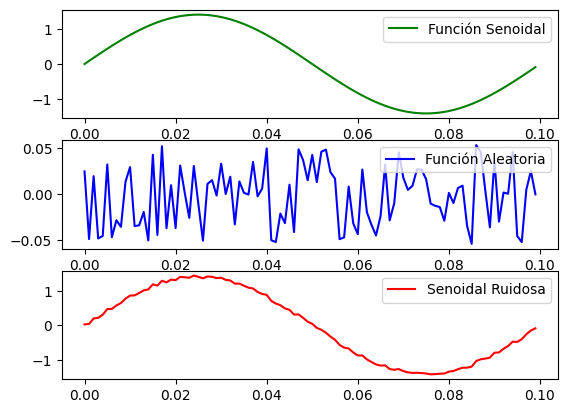

In [6]:
fig1, (ax1, ax2, ax3) = plt.subplots(3);

# Lo primero que voy a hacer es generarme la señal senoidal 
# sin_gen(Amp, DC, Frec, Phase, Muestras, Fs)
ax1.plot(t_axis,y_sin, color = 'green', label = 'Función Senoidal')
ax1.legend(loc = 'upper right');

# Luego voy a generar la señal aleatoria, donde el primero parámetro
# será la relación señal a ruido deseada y el segundo parámetro la 
# cantidad de muestras
ax2.plot(t_axis, y_noise, color = 'blue', label = 'Función Aleatoria')
ax2.legend(loc = 'upper right');

# Por último, voy a desnormalizar y realizar la suma de ambas
ax3.plot(t_axis, noisy_sin, color = 'red', label = 'Senoidal Ruidosa')
ax3.legend(loc = 'upper right');


Para esta primera etapa, voy a realizar la cuantización seguida del muestreo, voy a obviar el filtrado para observar los resultados que esto conlleva. Lo primero que haré es cada punto de mi señal original, lo redondearé y lo multiplicaré por la mínima cuenta del ADC, conocida como "cuanto" (Dependerá del número de bits y la tensión de referencia). Luego, me quedaré con una muestra cada N muestras de mi señal (decimación). Para finalizar, obtendré el ruido de cuantificación como la diferencia entre mi señal original y la señal cuantizada

In [7]:
# Primero voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin/quantum, decimals = 0) * quantum;
# Voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin - noisy_sin_quantif;

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 5;
t_axis_sampled = np.arange(0, N*1/f_cont, 1/(f_cont/ovs_rate));

# Primero voy a realizar el sampleo de la señal de forma directa, sin 
# filtrar, para observar cuales son los resultados
noisy_sin_quantif_sampled = noisy_sin_quantif[::ovs_rate]
quantif_noise_sampled = quantif_noise[::ovs_rate];

Los resultados son los siguientes:

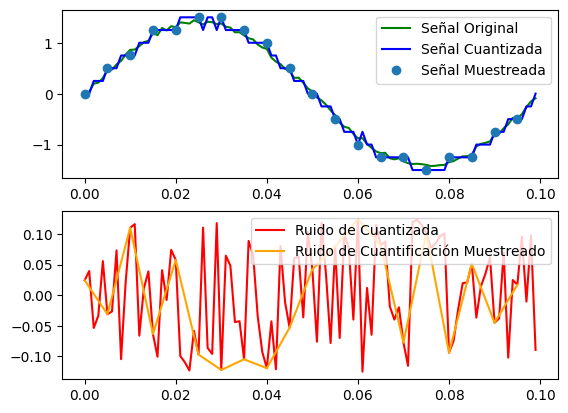

In [8]:
fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(t_axis, noisy_sin, color = 'green', label = 'Señal Original')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis, noisy_sin_quantif, color = 'blue', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis_sampled, noisy_sin_quantif_sampled, 'o', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(t_axis, quantif_noise, color = 'red', label = 'Ruido de Cuantizada')
ax2.legend(loc = 'upper right');
ax2.plot(t_axis_sampled, quantif_noise_sampled, color = 'orange', label = 'Ruido de Cuantificación Muestreado')
ax2.legend(loc = 'upper right');

Se observa como existe una diferencia entre la señal muestreada y la cuantizada, esto es justamente el ruido de cuantización (señal roja).
<br> Observemos ahora que pasa al aumentar la cantidad de bits que posee el ADC

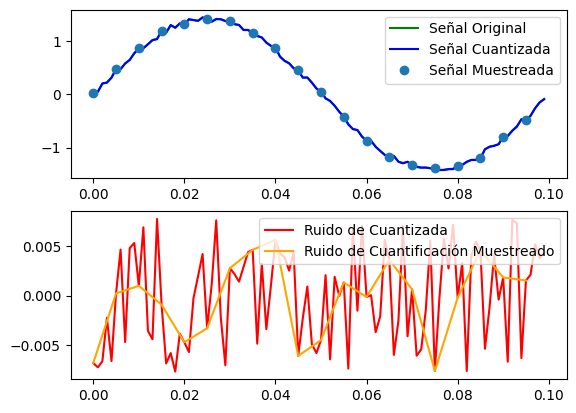

In [9]:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 8;                     # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

# Primero voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin/quantum, decimals = 0) * quantum;
# Voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin - noisy_sin_quantif;

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 5;

t_axis_sampled = np.arange(0, N*1/f_cont, 1/(f_cont/ovs_rate));

# Primero voy a realizar el sampleo de la señal de forma directa, sin 
# filtrar, para observar cuales son los resultados
noisy_sin_quantif_sampled = noisy_sin_quantif[::ovs_rate]
quantif_noise_sampled = quantif_noise[::ovs_rate];

fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(t_axis, noisy_sin, color = 'green', label = 'Señal Original')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis, noisy_sin_quantif, color = 'blue', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis_sampled, noisy_sin_quantif_sampled, 'o', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(t_axis, quantif_noise, color = 'red', label = 'Ruido de Cuantizada')
ax2.legend(loc = 'upper right');
ax2.plot(t_axis_sampled, quantif_noise_sampled, color = 'orange', label = 'Ruido de Cuantificación Muestreado')
ax2.legend(loc = 'upper right');

A simple vista, para un B = 8, la señal muestreada es prácticamente igual a la señal cuantizada. A modo de ejemplo, se hará lo mismo pero para B = 12:

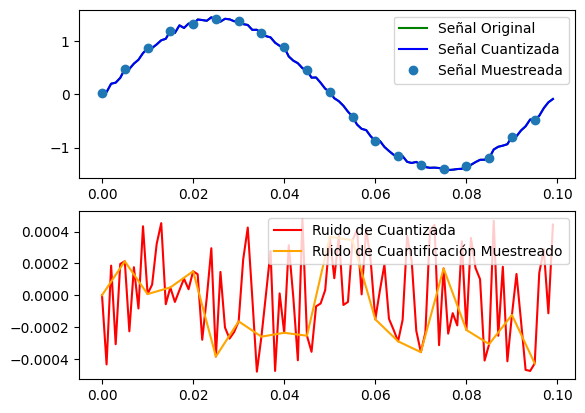

In [10]:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 12;                    # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

# Primero voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin/quantum, decimals = 0) * quantum;
# Voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin - noisy_sin_quantif;

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 5;

t_axis_sampled = np.arange(0, N*1/f_cont, 1/(f_cont/ovs_rate));

# Primero voy a realizar el sampleo de la señal de forma directa, sin 
# filtrar, para observar cuales son los resultados
noisy_sin_quantif_sampled = noisy_sin_quantif[::ovs_rate]
quantif_noise_sampled = quantif_noise[::ovs_rate];

fig2, (ax1, ax2) = plt.subplots(2);

ax1.plot(t_axis, noisy_sin, color = 'green', label = 'Señal Original')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis, noisy_sin_quantif, color = 'blue', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis_sampled, noisy_sin_quantif_sampled, 'o', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(t_axis, quantif_noise, color = 'red', label = 'Ruido de Cuantizada')
ax2.legend(loc = 'upper right');
ax2.plot(t_axis_sampled, quantif_noise_sampled, color = 'orange', label = 'Ruido de Cuantificación Muestreado')
ax2.legend(loc = 'upper right');

Conclusión, a medida que aumentamos la cantidad de bits en nuestro ADC disminuirá el ruido de cuantificación. La desventaja de esto es que el ADC comenzará a ser cada vez mas costoso. Por otro lado, hay que tener en cuenta que al aumentar el número de bits, los simbolos cercanos al cero estarán estar ocultos por el ruido (Es por ello que existe el concepto de ENOB)

Seguido de esto, voy a realizar una representación espectral de todas las señales obtenidas, lo que me permitirá sacar algunas conclusiones. <br> Para realizar las simulaciones en frecuencia voy a trabajar con un $\Delta{f}$ normalizado ya que me permitirá tener una mayor resolución espectral

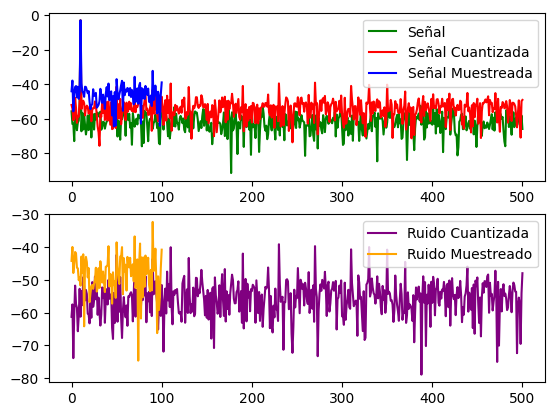

In [11]:
# Defino los datos del ADC:
Vr = 2;                         # Tensión de referencia del ADC
n_bits = 4;                     # Cantidad de bits del ADC
quantum = Vr / (2**(n_bits-1)); # Calculo el valor del cuanto (Cada paso del ADC)

# Con esta frecuencia representaré la señal analógica 
# En este caso la resolción espectral será de 1 (Normalizado)

f_cont  = 1000      # Frecuencia continua
N       = f_cont    # Cantidad de muestras de señal continua

# Establezco la frecuencia de mi señal senoidal, la relación señal a ruido
# que tendrá y la amplitud de la misma (En este caso, unitaria)

f_sin   = 10; # Frecuencia de mi senoidal
snr     = 30; # Relación señal a ruido
A_sin   = math.sqrt(2);  # Amplitud de Senoidal

# Me creo un eje temporal con el que voy a plotear mis señales
t_axis = np.arange(0, N*1/f_cont, 1/f_cont);

t, y_sin = sin_gen(A_sin, 0, f_sin, 0, N, f_cont)
y_noise = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
noisy_sin = y_sin + y_noise;

# Primero voy a realizar la cuantificación, para ello voy a generar el redondeo
# de cada una de las muestras y luego multiplicarlas por el cuanto
noisy_sin_quantif = np.round(noisy_sin/quantum, decimals = 0) * quantum;
# Voy a obtener el ruido de cuantificación haciendo la resta entre
# la señal original y la señal cuantizada
quantif_noise = noisy_sin - noisy_sin_quantif;

# Lo que voy a hacer ahora, para simular un muestreador, es quedarme con
# una muestra cada "ovs_rate" muestras.
ovs_rate = 5;
t_axis_sampled = np.arange(0, N*1/f_cont, 1/(f_cont/ovs_rate));

# Primero voy a realizar el sampleo de la señal de forma directa, sin 
# filtrar, para observar cuales son los resultados
noisy_sin_quantif_sampled = noisy_sin_quantif[::ovs_rate]
quantif_noise_sampled = quantif_noise[::ovs_rate];

frec_axis_cont = np.arange(0, f_cont, f_cont/N);
frec_axis = np.arange(0, (f_cont/ovs_rate), f_cont/N);
frec_axis_cont_filt = (frec_axis_cont <= f_cont/2);
frec_axis_filt = (frec_axis <= (f_cont/ovs_rate)/2);

# Ahora voy a obtener los espectros de la señal de trabajo, la muestreada, la
# cuantificada y el ruido de cuantificación
fft_noisy_sin = 20*np.log10(np.abs(np.fft.fft(noisy_sin)/N));
fft_noisy_sin_quantif = 20*np.log10(np.abs(np.fft.fft(noisy_sin_quantif)/N));
fft_quantif_noise = 20*np.log10(np.abs(np.fft.fft(quantif_noise)/N));
fft_noisy_sin_sampled = 20*np.log10(np.abs(np.fft.fft(noisy_sin_quantif_sampled)/(N/ovs_rate)));
fft_quantif_noise_sampled = 20*np.log10(np.abs(np.fft.fft(quantif_noise_sampled)/(N/ovs_rate)));

fig3, (ax1, ax2) = plt.subplots(2);

ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin[frec_axis_cont_filt], color = 'green', label = 'Señal')
ax1.legend(loc = 'upper right');
ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin_quantif[frec_axis_cont_filt], color = 'red', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(frec_axis[frec_axis_filt], fft_noisy_sin_sampled[frec_axis_filt], color = 'blue', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(frec_axis_cont[frec_axis_cont_filt], fft_quantif_noise[frec_axis_cont_filt], color = 'purple', label = 'Ruido Cuantizada')
ax2.legend(loc = 'upper right');
ax2.plot(frec_axis[frec_axis_filt], fft_quantif_noise_sampled[frec_axis_filt], color = 'orange', label = 'Ruido Muestreado')
ax2.legend(loc = 'upper right');

Lo que primero podemos observar es que luego de realizar la cuantización, el piso de ruido aumentó, pero como ya vimos anteriormente, esto se debe al error aleatorio generado al momento de la cuantización (Al final de la tarea se estudiarán sus estocásticos y distribución). Lo interesante de observar, es que luego del muestreo, el piso sevió incrementado nuevamente. Este efecto puede ser atribuido al <b>Aliasing Digital</b> producto de realizar el diezmado de la señal sin realizar el filtrado previo.
<br> Observemos ahora que ocurre cuando se coloca el filtro: </br>

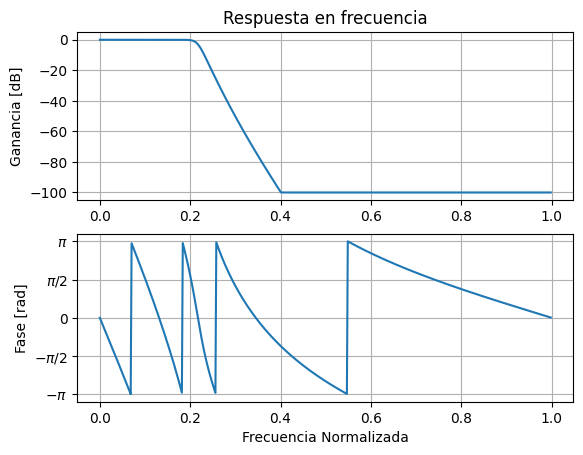

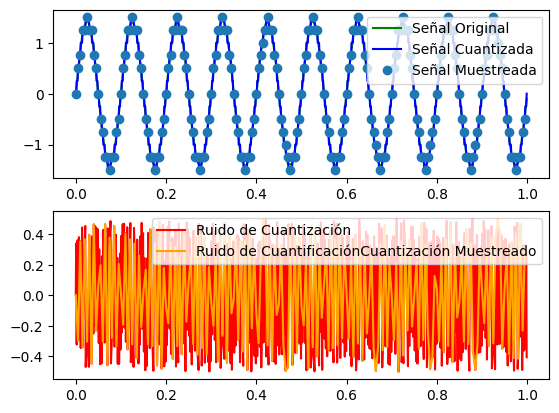

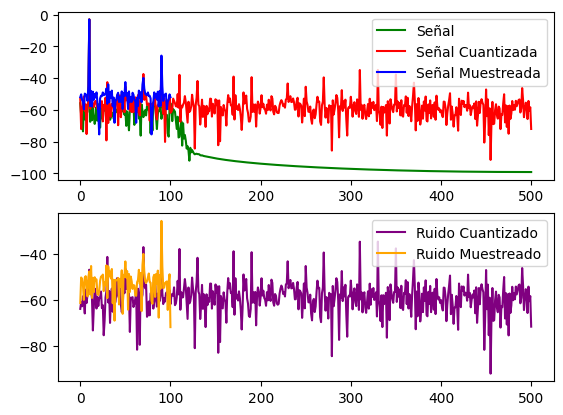

In [12]:
# Ahora voy a calcular un filtro que me permita eliminar todas las frecuencias
# por encima de fcont/(2*ovs_rate)
sos_filt = get_filter_tf(rate = ovs_rate);

# Obtengo la magnitud y la fase del filtro
w_filt, h_filt = sig.sosfreqz(sos_filt);

# Voy a graficar la plantilla del filtro que calculé previamente:
fig4,(ax1,ax2) = plt.subplots(2);
h_filt_abs_db = 20*np.log10(np.maximum(np.abs(h_filt), 1e-5));
ax1.plot(w_filt/np.pi, h_filt_abs_db);
ax1.grid(True);
ax1.set_ylabel('Ganancia [dB]');
ax1.set_title('Respuesta en frecuencia');
ax2.plot(w_filt/np.pi, np.angle(h_filt));
ax2.grid(True);
ax2.set_yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']);
ax2.set_ylabel('Fase [rad]');
ax2.set_xlabel('Frecuencia Normalizada');

# Ahora se lo voy a aplicar a mi señal, voy a realizar, voy a cuantizar,
# luego muestrear y al final voy a mostrar los resultados:
# Filtrado:
noisy_sin_filt = sig.sosfiltfilt(sos_filt, noisy_sin);
# Cuantización:
sin_filt_quant = np.round(noisy_sin_filt/quantum, decimals = 0) * quantum;
quant_noise_filt = noisy_sin_filt - sin_filt_quant;
# Muestreo:
sin_filt_quant_sampled = sin_filt_quant[::ovs_rate]
quant_noise_filt_sampled = quant_noise_filt[::ovs_rate];

fig5, (ax1, ax2) = plt.subplots(2);

ax1.plot(t_axis, noisy_sin_filt, color = 'green', label = 'Señal Original')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis, sin_filt_quant, color = 'blue', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(t_axis_sampled, sin_filt_quant_sampled, 'o', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(t_axis, quant_noise_filt/quantum, color = 'red', label = 'Ruido de Cuantización')
ax2.legend(loc = 'upper right');
ax2.plot(t_axis_sampled, quant_noise_filt_sampled/quantum, color = 'orange', label = 'Ruido de CuantificaciónCuantización Muestreado')
ax2.legend(loc = 'upper right');

# Ahora voy a obtener los espectros de la señal de trabajo, la muestreada, la
# cuantificada y el ruido de cuantificación
fft_sin_filt = 20*np.log10(np.abs(np.fft.fft(noisy_sin_filt)/N));
fft_sin_quant_filt = 20*np.log10(np.abs(np.fft.fft(sin_filt_quant)/N));
fft_quant_noise_filt = 20*np.log10(np.abs(np.fft.fft(quant_noise_filt)/N));
fft_sin_filt_quant_sampled = 20*np.log10(np.abs(np.fft.fft(sin_filt_quant_sampled)/(N/ovs_rate)));
fft_quant_noise_filt_sampled = 20*np.log10(np.abs(np.fft.fft(quant_noise_filt_sampled)/(N/ovs_rate)));

fig3, (ax1, ax2) = plt.subplots(2);

ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_sin_filt[frec_axis_cont_filt], color = 'green', label = 'Señal')
ax1.legend(loc = 'upper right');
ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_sin_quant_filt[frec_axis_cont_filt], color = 'red', label = 'Señal Cuantizada')
ax1.legend(loc = 'upper right');
ax1.plot(frec_axis[frec_axis_filt], fft_sin_filt_quant_sampled[frec_axis_filt], color = 'blue', label = 'Señal Muestreada')
ax1.legend(loc = 'upper right');

ax2.plot(frec_axis_cont[frec_axis_cont_filt], fft_quant_noise_filt[frec_axis_cont_filt], color = 'purple', label = 'Ruido Cuantizado')
ax2.legend(loc = 'upper right');
ax2.plot(frec_axis[frec_axis_filt], fft_quant_noise_filt_sampled[frec_axis_filt], color = 'orange', label = 'Ruido Muestreado')
ax2.legend(loc = 'upper right');


Se observa claramente como luego del filtrado y una vez muestreada la señal, el piso de ruido es mucho mas bajo (casi 10dB) que en el primer caso. Por otro lado, el ruido de cuantización se mantiene en los mismos niveles ya que este no debe verse afectado por el filtrado.

#### Segunda Parte - Estocásticos

Voy a aprovechar esta última simulación para estudiar algunas características de la señal de ruido. 
<br> Sabemos que es una señal estocástica por lo que no tendrá una ley que la rija. Por lo tanto, los parámetros que nos interesan de la misma son sus "estocásticos", entre ellos su valor medio y varianza.
<br> Primero que nada, el ruido será normalizado entre Q/2 y -Q/2 para que su representación sea un poco mas amena. Por otro lado, podremos obtener un aproximado de la distribución si imprimimos un histograma de la señal. Lo que hacemos con esto es observar "cuantas veces" ocurrió una determinado cuanto. Si todo es correcto, debería asemejarse a una distribución uniforme, ya que cada cuanto tiene la misma probabilidad de ocurrir, por lo que la cantidad de veces que ocurre cada uno, debería ser la misma.

El valor medio es: -0.0008648505642460509 el cual debería ser cercano a cero
La varianza obtenida de suponer una distribución uniforme es: 0.005208333333333333
La varianza obtenida a partir de la expresión de numpyy es: 0.005760223412084145
La varianza obtenida a partir de suponer un ruido totalmente incorrelacionado es 0.00576097137858262


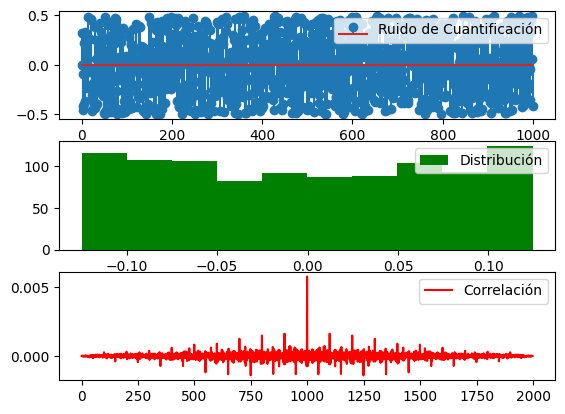

In [14]:
# Obtengo el valor medio del ruido de cuantificación, el cual debería 
# ser cero
mean_quantif_noise = np.mean(quantif_noise);

# Tengo tres formas distintas de obtener la varianza del ruido: La primera
# de ellas se obtiene de suponer una distribución uniforme del mismo, la 
# segunda es a través de la herramienta de cálculo que proporciona numpy,
# y la última, se obtiene de la autocorrelación de la señal. Esta última se
# cumplirá unicamente si el ruido está totalmente incorrelacionado, obteniendo
# un delta de kronecker en el origen (representando la energía de la señal)
var_quantif_noise_1 = (np.float64(quantum)**2)/12
var_quantif_noise_2 = np.var(quantif_noise)
var_quantif_noise_3 = sig.correlate(quantif_noise, quantif_noise)/N

fig3, (ax1, ax2, ax3) = plt.subplots(3);

# Voy a imprimir el ruido de cuantización normalizado en quantum, esto me 
# fijará el límite superior en quantum/2 y el inferior en -quantum/2
ax1.stem(quantif_noise/quantum, label = 'Ruido de Cuantificación')
ax1.legend(loc = 'upper right');

# Por otro lado, voy a imprimir la distribución, que se todo salió acorde 
# a la teoría, debería ser uniforme
ax2.hist(quantif_noise, color = 'green', label = 'Distribución');
ax2.legend(loc = 'upper right');

# Por último, voy a imprimir los resultados de la autocorrelación de la señal
# Si todo es correcto, debería haber una delta en el origen cuya amplitud
# es igual a la varianza del ruido
ax3.plot(var_quantif_noise_3, color = 'red', label = 'Correlación');
ax3.legend(loc = 'upper right');

print("El valor medio es:",mean_quantif_noise,"el cual debería ser cercano a cero")
print("La varianza obtenida de suponer una distribución uniforme es:", var_quantif_noise_1)
print("La varianza obtenida a partir de la expresión de numpyy es:", var_quantif_noise_2)
print("La varianza obtenida a partir de suponer un ruido totalmente incorrelacionado es", max(var_quantif_noise_3))

Como conclusión puedo decir:
 - El valor medio obtenido es prácticamente nulo (Existe un error númerico al realizar el cálculo) 
 - Se calculó la varianza de 3 formas distintas y en todos los casos se obtuvo un resultado similar, indicando, por un lado, que la señal tendrá una distribución uniforme y a su vez, estará totalmente incorrelacionada. Esto último se puede observar en el gráfico de la correlación, donde tenemos una delta de Kronecker en el origen indicando que existirá una similitud entre muestras unicaménte cuando la señal con su conjugada se encuentren solapadas, es decir, desplazamiento nulo (pensando en el cálculo de la autocorrelación). 